# Exploring Genomic Data

This notebook demonstrates working with genetic variant data stored as publicly accessible Google BigQuery datasets.

Specifically, we will work with the [Illumina Platinum Genomes](https://cloud.google.com/genomics/data/platinum-genomes) data. The source data was originally in [VCF format](http://vcftools.sourceforge.net/VCF-poster.pdf), which was imported to [Google Genomics](https://cloud.google.com/genomics/) and exported to BigQuery.

If you want to explore other genomics samples, see https://github.com/googlegenomics/datalab-examples. You can import them into your Google Cloud Datalab instance by uploading them from the notebook list page.

In [1]:
import google.datalab.bigquery as bq

## Variants

Let's start with a little bit of genomics nomenclature:

 * **Variant**: A region of the genome that has been identified as differing from the reference genome.
 * **Non-variant Segment**: A region of the genome that matches the reference genome. 
 * **Reference Name**: The name of a reference segment of DNA. Typically, this is a chromosome, but it may be other named regions from a reference genome.
 * **Reference Bases**: The A's, C's, T's, and G's comprising the DNA of the reference genome at the site of variation.
 * **Alternate Bases**: The A's, C's, T's, and G's comprising the DNA actually found at the site of variation for the sample(s) sequenced.
 * **SNP**: A [single nucleotide polymorphism](https://en.wikipedia.org/wiki/Single-nucleotide_polymorphism) is a DNA sequence variation in which a single nucleotide — A, T, C or G — in the genome (or other shared sequence) differs between members of a biological species or paired chromosomes.


In [2]:
variants = bq.Table('genomics-public-data.platinum_genomes.variants')
variants.length

261285806

Wow, that's a lot of records!  For a detailed description of the schema, see [Understanding the BigQuery Variants Table Schema](https://cloud.google.com/genomics/v1/bigquery-variants-schema).

## SNPs

Next, let's take a look at a few SNPs in our data.  As mentioned in the nomenclature, SNPs are a particular kind of genetic variant. Let's create an SQL statement that can list all variant records for a single base change:

In [3]:
%%bq query --name single_base
SELECT
  reference_name,
  start,
  reference_bases,
  alternate_bases
FROM
  `genomics-public-data.platinum_genomes.variants`
WHERE
  reference_bases IN ('A','C','G','T') AND
  ARRAY_LENGTH(alternate_bases) = 1
LIMIT 100

In [4]:
%bq execute --query single_base

reference_name,start,reference_bases,alternate_bases
chr13,55705238,A,['C']
chr6,87341707,A,['C']
chr9,135065442,A,['C']
chr3,172106165,A,['G']
chr1,236345163,A,['G']
chr14,97175506,A,['G']
chr2,160217510,A,['G']
chr5,133727302,A,['G']
chr2,130951580,A,['G']
chr6,93866087,A,['G']


## Transition/Transversion Ratio

A SNP can be further classified as either a [transition](https://en.wikipedia.org/wiki/Transition_%28genetics%29) or a [transversion](https://en.wikipedia.org/wiki/Transversion). The ratio of transitions to transversions (TiTv ratio) in humans is observed to be approximately 2.1, but this is not uniform across the genome. Let's take a closer look by computing the TiTv ratio in contiguous regions of 100,000 base pairs.

In [5]:
%%bq query --name snps
SELECT
  reference_name,
  reference_bases,
  alternate_bases,
  CAST(FLOOR(start / 100000) AS INT64) AS windows,
  CONCAT(reference_bases, CONCAT(CAST('->' AS STRING), ARRAY_TO_STRING(alternate_bases, ''))) AS mutation,
  ARRAY_LENGTH(alternate_bases) AS num_alts
FROM
  `genomics-public-data.platinum_genomes.variants`
WHERE reference_name IN ("1", "chr1")
  # Limit to bi-allelic SNP variants
  AND reference_bases IN ('A','C','G','T')
  AND ARRAY_LENGTH(alternate_bases) = 1

We've updated the above query to include the "window" in which the SNP resides, and added a new field called "mutation".

In [6]:
%bq sample -q snps --count 10

reference_name,reference_bases,alternate_bases,windows,mutation,num_alts
chr1,A,['G'],1062,A->G,1
chr1,A,['G'],1203,A->G,1
chr1,C,['T'],2020,C->T,1
chr1,C,['A'],2372,C->A,1
chr1,G,['A'],2244,G->A,1
chr1,G,['C'],31,G->C,1
chr1,G,['T'],219,G->T,1
chr1,G,['A'],1142,G->A,1
chr1,G,['A'],58,G->A,1
chr1,T,['A'],2259,T->A,1


Next we group and classify the SNPs within their windows.

In [7]:
%%bq query --name windows --subqueries snps
SELECT
  reference_name,
  windows AS win,
  COUNTIF(mutation IN ('A->G', 'G->A', 'C->T', 'T->C')) AS transitions,
  COUNTIF(mutation IN ('A->C', 'C->A', 'G->T', 'T->G',
                       'A->T', 'T->A', 'C->G', 'G->C')) AS transversions,
  COUNT(mutation) AS num_variants_in_window
  FROM snps
GROUP BY
  reference_name,
  win

In [8]:
%bq sample -q windows --count 10

reference_name,win,transitions,transversions,num_variants_in_window
chr1,1893,103,64,183
chr1,691,130,89,235
chr1,1071,139,108,262
chr1,1560,144,108,266
chr1,1132,164,115,294
chr1,250,137,142,303
chr1,2029,245,164,439
chr1,68,194,176,406
chr1,2005,238,180,455
chr1,1615,371,227,609


And finally, we compute the per-window TiTv ratio.

In [9]:
%%bq query --name titv --subqueries snps windows
SELECT
  reference_name,
  win * 100000 AS window_start,
  transitions,
  transversions,
  transitions/transversions AS titv,
  num_variants_in_window
FROM windows
ORDER BY
    window_start

In [10]:
%bq sample -q titv --count 10

reference_name,window_start,transitions,transversions,titv,num_variants_in_window
chr1,0,232,156,1.48717948718,397
chr1,100000,118,56,2.10714285714,177
chr1,200000,55,37,1.48648648649,94
chr1,300000,1,8,0.125,9
chr1,400000,21,11,1.90909090909,32
chr1,500000,160,49,3.26530612245,210
chr1,600000,63,43,1.46511627907,107
chr1,700000,278,252,1.10317460317,544
chr1,800000,906,619,1.46365105008,1562
chr1,900000,365,300,1.21666666667,698


In [11]:
titvRatios = titv.execute(output_options=bq.QueryOutput.dataframe()).result()
titvRatios[:5]

,reference_name,window_start,transitions,transversions,titv,num_variants_in_window
0,chr1,0,232,156,1.487179,397
1,chr1,100000,118,56,2.107143,177
2,chr1,200000,55,37,1.486486,94
3,chr1,300000,1,8,0.125000,9
4,chr1,400000,21,11,1.909091,32


## Visualization

Now we can take the ratios and plot them by genomic position to see how the ratio varies depending upon where it was computed within the chromosome. By default, this plot shows chromosome 1 with its gap in the center of the data corresponding to its [metacentric contromere](https://en.wikipedia.org/wiki/Centromere#Metacentric).

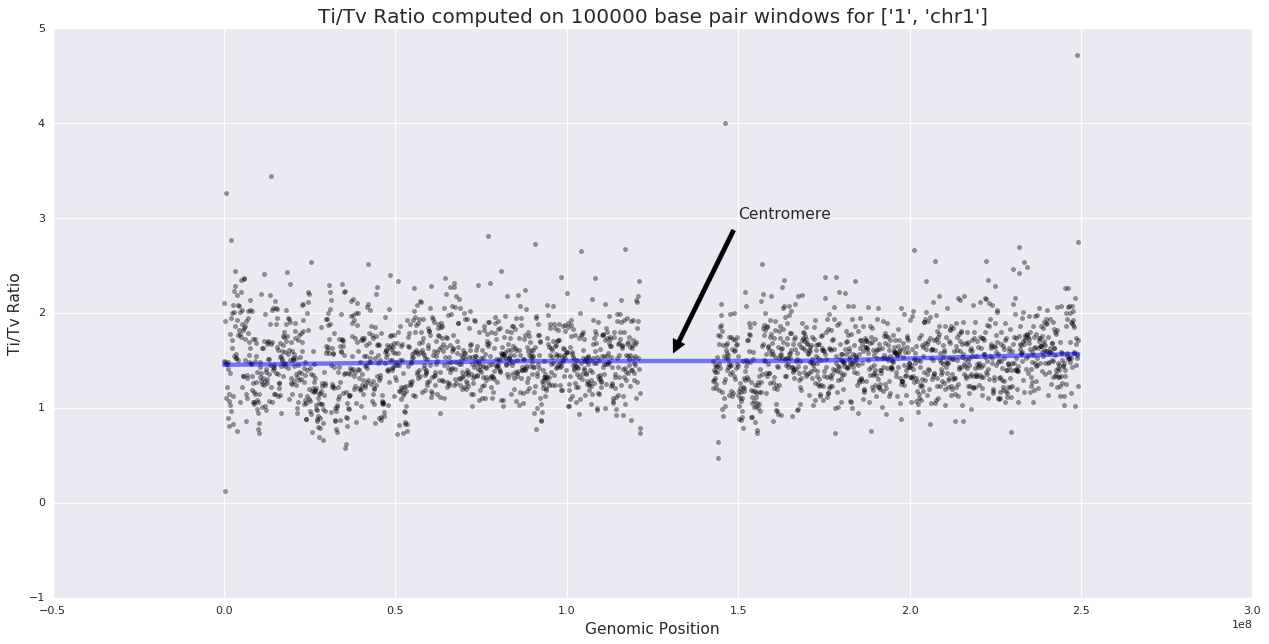

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.lmplot(x='window_start',
               y='titv',
               data = titvRatios,
               size = 8,
               aspect = 2,
               scatter_kws = { 'color': 'black', 'alpha': 0.4 },
               line_kws = { 'color': 'blue', 'alpha': 0.5, 'lw': 4 },
               lowess = True)
plt.xlabel('Genomic Position', fontsize = 14)  
plt.ylabel('Ti/Tv Ratio', fontsize = 14)
plt.title('Ti/Tv Ratio computed on %d base pair windows for %s' % (100000, ['1', 'chr1']),
          fontsize = 18)
plt.annotate('Centromere', xy = (1.3e8, 1.5), xytext = (1.5e8, 3), size = 14,
             arrowprops=dict(facecolor='black', shrink=0.05))